<a href="https://www.kaggle.com/code/syerramilli/planttraits-efficientnet-image-tabular?scriptVersionId=179197800" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images and the ancillary data (satellite data, soil data, climate data etc.) to predict the 6 plant properties.

**CHANGELOG**:

v1 -> v2: 
1. Replaced EfficientNet V1 with V2
2. Removed the rescaling layer prior to EfficientNet. This layer was erroneously included.

v2 -> v3:
Increased the number of training epochs (10 -> 15)

v3 -> v4:
1. Further Increased the number of training epochs (15 -> 25)
2. Set the number of warmup steps as a percentage (20%) of the total number of optimization steps

v4 -> v5:
Dropping highly correlated features in the tabular data through hierarchical clustering

v5 -> v8:
1. Enabled training the efficientnet weights along with the rest of the network 
2. Reduced the number of training epochs (25 -> 20)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
import keras
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-05-22 21:47:01.835434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 21:47:01.835591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 21:47:01.990466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## global configuration
CFG = {
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 20,
    'MAX_LR': 5e-4,
    'WARMUP_PCT': 0.2,
    'n_tabular_layers': 2,
    'img_backbone_final_dim': 128,
    'tabular_hsizes': [256, 128],
    'n_ff_layers': 2,
    'ff_hsizes': [128, 64]
}

## Loading the data

In [3]:
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [4]:
targets = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

In [5]:
# remove sd columns
sd_cols = [f'{col}_sd' for col in targets]
train = train.drop(columns = sd_cols)

## Preprocessing

In [6]:
img_paths = train['img_path'].astype(str).values
tabular = train.drop(columns = ['id', 'img_path'] + target_cols)
Y = train[target_cols]

In [7]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
img_paths = img_paths[retained_flag]
tabular = tabular[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

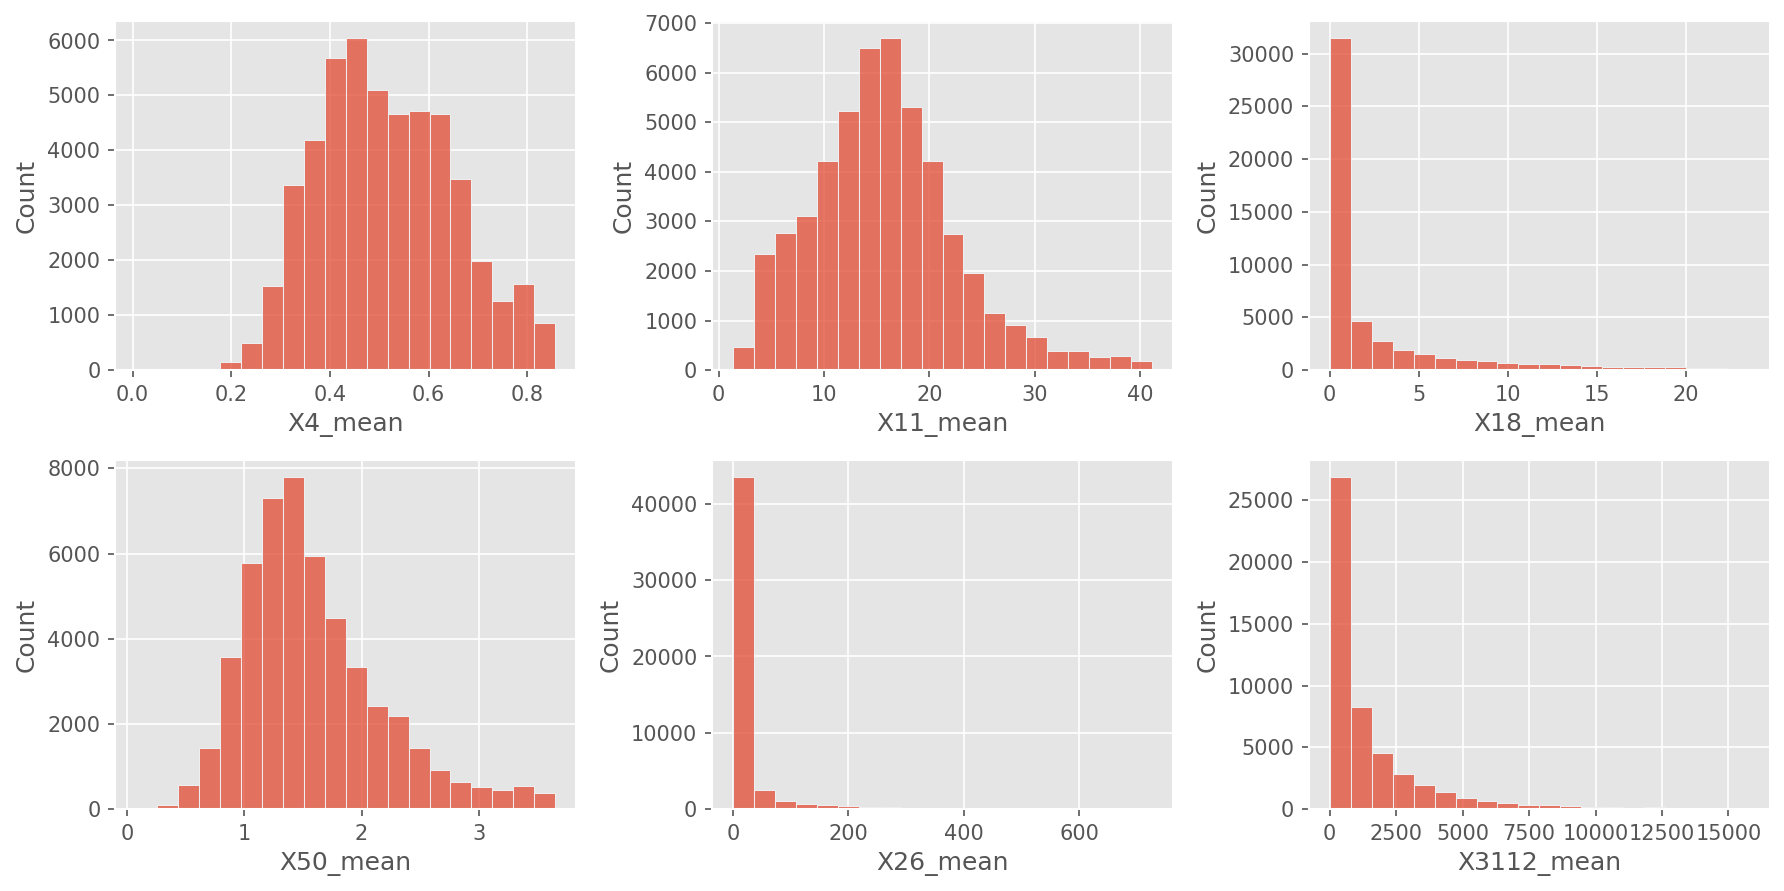

In [8]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()


In [9]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)
_ = joblib.dump(output_sc, 'output_scaler.pkl')

## Tabular preprocessing

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$
where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [10]:
# construct correlation matrix
corr_matrix = tabular.corr(method='spearman')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

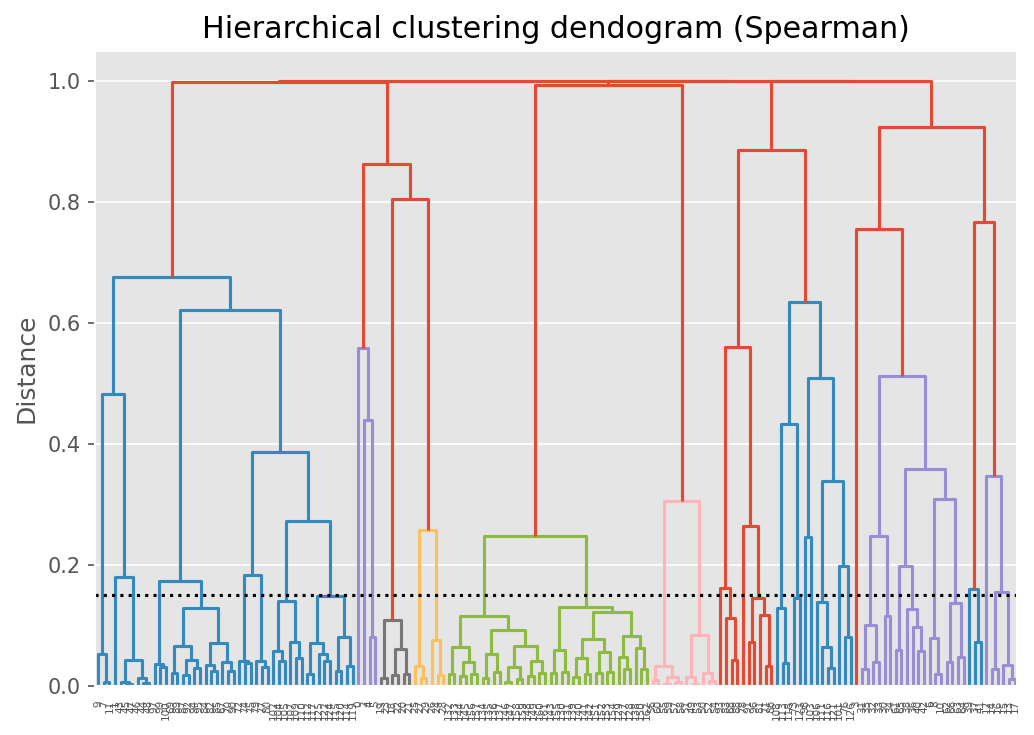

In [11]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
#     labels=corr_matrix.columns.tolist(),
)
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram (Spearman)')
_ = ax.axhline(0.15, 0, 1, linestyle='dotted', color='k')
_ = ax.grid(False, axis='x')
fig.tight_layout()

We will now generate the cluster labels for each feature. The number of clusters will depend on the distance we use as threshold. For smaller distance thresholds, more clusters will be formed. Here, we use a distance threshold of 0.15. 

In [12]:
# get the cluster labels
threshold = 0.15
cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]
print(f'Number of clusters: {n_clusters}\n')

Number of clusters: 42



In [13]:
import json
cluster_features = {}

# show features within each cluster
for label in range(1, n_clusters + 1):
    #print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = corr_matrix.columns[leaves_in_cluster].tolist()
    #print(cluster_features[label])
    #print()
    
with open('feature_clusters.json', 'w') as f:
    json.dump(cluster_features, f)

Finally, we will select only one feature from each cluster. 

In [14]:
final_features = []
for cols_in_cluster in cluster_features.values():
    final_features.append(cols_in_cluster[0])
    
tabular = tabular[final_features]

For the select features, we will apply min-max normalization. 

In [15]:
# normalize tabular inputs
tabular_input_sc = MinMaxScaler()
tabular_sc = tabular_input_sc.fit_transform(tabular).astype(np.float32)
_ = joblib.dump(tabular_input_sc, 'tabuler_input_scaler.pkl')

## Image preprocessing functions

In [16]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    # preprocessing for efficient net 
    # per documentation, does nothing; including it
    # here for consistency
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, tabular, targets):
    return (process_image_from_file(file_path), tabular), targets


## Create training and validation sets

In [17]:
paths_train, paths_val, tabular_train, tabular_val, Y_train, Y_val = train_test_split(
    img_paths, tabular_sc, Y_sc, random_state=2, test_size=0.2
)

train_ds = tf.data.Dataset.from_tensor_slices((paths_train, tabular_train.astype(np.float32), Y_train.astype(np.float32)))
val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32), Y_val.astype(np.float32)))


# preprocess and batch
train_ds = train_ds.map(process_path).batch(CFG['BATCH_SIZE'])
val_ds = val_ds.map(process_path).batch(CFG['BATCH_SIZE'])

## Model architecture

In [18]:
keras.backend.clear_session()


############################## 
# IMG Processing
############################## 
img_input = keras.layers.Input(shape = (224, 224, 3), name="img_input")

img_backbone = keras.Sequential([
    # augmentation layers
    keras.Sequential([
        keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
        keras.layers.RandomTranslation(
            height_factor=0.1, width_factor=0.1, interpolation='nearest'
        ),
        keras.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras.layers.RandomFlip(mode="horizontal_and_vertical")
    ], name='augmentation'),
    EfficientNetV2B0(include_top=False, weights='imagenet'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(CFG['img_backbone_final_dim'])
], name='img_backbone')

# # fix efficientnet weights 
# img_backbone.get_layer('efficientnetv2-b0').trainable = False

img_output = img_backbone(img_input)

############################## 
# Tabular Processing
##############################
tabular_input = keras.layers.Input(shape = (tabular_sc.shape[1],) , name="tabular_input")

backbone_blocks = []
for i in range(CFG['n_tabular_layers']):
    backbone_blocks.extend([
        keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'tabular_block_{i}_dense'),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.1)
    ])
    
tabular_backbone = keras.Sequential(backbone_blocks, name='tabular_backbone')
tabular_output = tabular_backbone(tabular_input)

##############################
# Concat and outputs
##############################
output = keras.layers.Concatenate()([img_output, tabular_output])
for i in range(CFG['n_ff_layers']):
    output = keras.layers.Dense(CFG['tabular_hsizes'][i], name=f'ff_block_{i}_dense')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.ReLU()(output)
    output = keras.layers.Dropout(0.1)(output)


output = keras.layers.Dense(6, name='output')(output)

model = keras.Model(inputs=[img_input, tabular_input], outputs=output)


num_steps_per_epoch = len(train_ds)
total_steps = CFG['NUM_EPOCHS'] * num_steps_per_epoch
warmup_steps = np.ceil(CFG['WARMUP_PCT'] * total_steps).astype(int)


lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 1e-5,
    decay_steps = total_steps - warmup_steps,
    warmup_target= CFG['MAX_LR'],
    warmup_steps = warmup_steps
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss= keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.R2Score()]
)

print(model.summary())

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_backbone        │ (None, 128)       │  6,083,280 │ img_input[0][0]   │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_backbone    │ (None, 128)       │     45,440 │ tabular_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ img_backbone[0][… │
│ (Concatenate)       │                   │            │ tabular_backbone… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_block_0_dense    │ (None, 256)       │     65,792 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ ff_block_0_dense… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ff_block_1_dense    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ ff_block_1_dense… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,229,718 (23.76 MB)

 Trainable params: 6,167,574 (23.53 MB)

 Non-trainable params: 62,144 (242.75 KB)

None


## Training

In [19]:
history = model.fit(train_ds, validation_data=val_ds, epochs=CFG['NUM_EPOCHS'])

Epoch 1/20


2024-05-22 21:48:11.278343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/img_backbone_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


312/312 ━━━━━━━━━━━━━━━━━━━━ 239s 590ms/step - loss: 1.7150 - r2_score: -0.7347 - val_loss: 0.9142 - val_r2_score: 0.0877
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 182s 555ms/step - loss: 1.0367 - r2_score: -0.0495 - val_loss: 0.7984 - val_r2_score: 0.2034
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 198s 541ms/step - loss: 0.8638 - r2_score: 0.1256 - val_loss: 0.7519 - val_r2_score: 0.2501
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 169s 542ms/step - loss: 0.7859 - r2_score: 0.2045 - val_loss: 0.7276 - val_r2_score: 0.2745
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 202s 542ms/step - loss: 0.7411 - r2_score: 0.2498 - val_loss: 0.7192 - val_r2_score: 0.2831
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 169s 542ms/step - loss: 0.7036 - r2_score: 0.2877 - val_loss: 0.7426 - val_r2_score: 0.2598
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 202s 543ms/step - loss: 0.6750 - r2_score: 0.3167 - val_loss: 0.7238 - val_r2_score: 0.2785
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 169s 542ms/step - loss: 0.6507 - r2_score: 0.

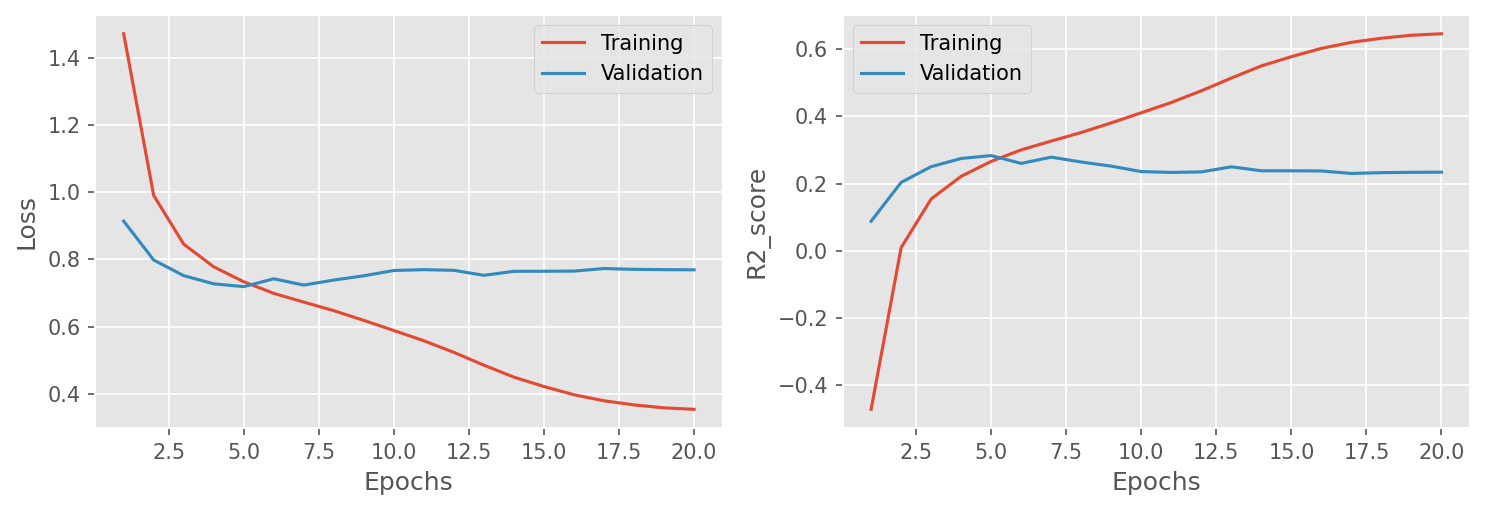

In [20]:
# plot training history
metrics = ['loss','r2_score']

fig,axs = plt.subplots(1, len(metrics), figsize=(5*len(metrics),3.5),dpi=150)

for i,metric in enumerate(metrics):
    
    _ = axs[i].plot(1 + np.arange(CFG['NUM_EPOCHS']), history.history[f'{metric}'],label='Training')
    _ = axs[i].plot(1 + np.arange(CFG['NUM_EPOCHS']), history.history[f'val_{metric}'],label='Validation')
    _ = axs[i].legend()
    _ = axs[i].set_ylabel(metric.capitalize())
    _ = axs[i].set_xlabel('Epochs')

fig.tight_layout()
fig.savefig('training_history.png',bbox_inches='tight')
fig.savefig('training_history.pdf',bbox_inches='tight')

In [21]:
# save weights
model.save_weights("model.weights.h5")

## Checking individual output R2

In [22]:
def process_paths_wo_targets(file_path, tabular):
    return ((process_image_from_file(file_path), tabular),)

# recreate the validation dataset without the targets
val_ds = tf.data.Dataset.from_tensor_slices((paths_val, tabular_val.astype(np.float32)))
val_ds = val_ds.map(process_paths_wo_targets).batch(256)

y_val_pred = model.predict(val_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step


In [23]:
val_r2_scores = pd.Series(
    r2_score(Y_val, y_val_pred, multioutput='raw_values'),
    index=target_cols,
)
print(val_r2_scores)

X4_mean       0.245946
X11_mean      0.233265
X18_mean      0.413995
X50_mean      0.125779
X26_mean      0.112858
X3112_mean    0.270697
dtype: float64


## Predictions on Test Data

In [24]:
paths_test = test['img_path'].astype(str).values
tabular_test = tabular_input_sc.transform(test[final_features]).astype(np.float32)
test_ds = tf.data.Dataset.from_tensor_slices((paths_test, tabular_test))
test_ds = test_ds.map(process_paths_wo_targets).batch(256)
predictions = model.predict(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 695ms/step


In [25]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

In [26]:
submission.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.646185,6.700583,2.642350,1.610432,9.478573,308.129272
1,202310319,0.372692,16.162447,0.591743,1.643650,6.262958,511.914673
2,202604412,0.696247,12.664742,1.700677,1.503449,13.954662,327.007202
3,201353439,0.457893,20.405870,0.746789,1.317595,2.830144,1325.646606
4,195351745,0.530387,14.478118,-0.191047,1.173349,5.659053,-254.872452
